# Notes on building a RILtaur

## from Main.cpp
    - multiple threads are running but the notable ones maybe:
        - waPositionControlThread, waDatalogThread, waIMUThread
        
## from Position Control
    as commented below are the states for switch case 
    and also the gait_params for each of teh gaits
    and the TROT case itself

In [1]:
# enum States {
#     STOP = 0,
#     TROT = 1,
#     BOUND = 2,
#     WALK = 3,
#     PRONK = 4,
#     JUMP = 5,
#     DANCE = 6,
#     HOP = 7,
#     TEST = 8,
#     ROTATE = 9,
#     FLIP = 10,
#     TURN_TROT = 11,
#     RESET = 12
# };


# struct GaitParams {
#     float stance_height = 0.18; // Desired height of body from ground during walking (m)
#     float down_amp = 0.00; // Peak amplitude below stanceHeight in sinusoidal trajectory (m)
#     float up_amp = 0.06; // Height the foot peaks at above the stanceHeight in sinusoidal trajectory (m)
#     float flight_percent = 0.6; // Portion of the gait time should be doing the down portion of trajectory
#     float step_length = 0.0; // Length of entire step (m)
#     float freq = 1.0; // Frequency of one gait cycle (Hz)
#     float step_diff = 0.0; //difference between left and right leg step length
# };


# case TROT: // line 62
#     gait(gait_params, 0.0, 0.25, 0.75, 0.5, gait_gains);
#     /**
#     the gait params are: {0.15, 0.00, 0.06, 0.25, 0.0, 1.5, 0.0}
#     stance_height Desired height of body from ground during walking (m)
#     down_amp Peak amplitude below stanceHeight in sinusoidal trajectory (m)
#     up_amp Height the foot peaks at above the s.h. in sinusoidal trajectory (m)
#     flight_percent Portion of the gait time for the down portion of trajectory
#     step_length Length of entire step (m)
#     freq Frequency of one gait cycle (Hz)
#     step_diff difference between left and right leg step length
#     **/
#     break;

In [ ]:
from collections import namedtuple
from math import sin, cos, acos, tan, atan, pi, sqrt
import time
import numpy as np
import matplotlib.pyplot as plt

GaitParams = namedtuple('GaitParams', ['stance_height', 'down_amp', 'up_amp', 'flight_percent', 'step_length', 'freq', 'step_diff'])
LegGain = namedtuple('LegGain', ['kp_theta', 'kd_theta', 'kp_gamma', 'kd_gamma'])

                     #   sh,   da,   ua,   fp,   sl,   fq,  sd
gait_params = GaitParams(0.17, 0.04, 0.06, 0.35, 0.15, 2.0, 0.0)
gait_gains = LegGain(80, 0.5, 50, 0.5)

# leg_offsets 0 to 3:  0.0, 0.5, 0.0, 0.5

class motor:
    def __init__(self, leg1, leg2, leg_direction, leg_offset, gaitParams):
        self.leg1 = leg1
        self.leg2 = leg2
        self.leg_direction = leg_direction
        self.x = 0
        self.y = 0
        self.p = 0
        self.leg_offset = leg_offset
        self.prev_t = 0
        self.gaitParams = gaitParams
        self.L = 0
        self.theta = 0
        self.gamma = 0
        
        self.alpha = 0
        self.gamma = 0
        
        self.old_time = 0
        
    def gait(self, params, leg_offset, gains):
        self.coupledMoveLeg()
        
    def coupledMoveLeg(self):
        t = time.process_time()
        self.sinTrajectory(t)
        self.cartesianToThetaGamma();
        self.pos_16()
        
#         self.setCoupledPosition();
        
    def sinTrajectory(self, t):
        sh, da, ua, fp, sl, fq, sd  = self.gaitParams
        
        dt = (t - self.prev_t) if (t - self.prev_t) < 0.5 else 0
        self.p += (fq*float(dt)) # possibly to track the nunber of gait cycles
        self.prev_t = t
        
        if (self.p == 0.0):
            self.old_time = time.time()
        elif (self.p >= 1.01 and self.p <= 1.001):
            print(time.time() - self.old_time)
            

        
        
        gp = (self.p + self.leg_offset)%1.0 # this gives you a value between 0 and 1 which is the gait percent 
                                            # this can be used to set the phase difference
        
        if (gp <= fp): # responsible for the flight patch
            self.x = ((gp/fp)*sl) - sl/2.0;
            self.y = (-1 * ua*sin(pi*gp/fp)) + sh;
        else:
            percentBack = (gp-fp)/(1.0-fp);
            self.x = (-1 * percentBack*sl) + sl/2.0;
            self.y = da*sin(pi*percentBack) + sh;
        
            
#     def sinTracj(self, t):
#         sh, da, ua, fp, sl, fq, sd  = self.gaitParams
        
#         if (gp <= fp): # responsible for the flight patch
#             self.x = ((gp/fp)*sl) - sl/2.0;
#             self.y = (-1 * ua*sin(pi*gp/fp)) + sh;
            
    def cartesianToThetaGamma(self):
        self.L = 0
        self.cartesianToLegParams()
        self.getGamma()
        
    def cartesianToLegParams(self):
        l_squared = (self.x**2.0) + (self.y**2.0)
        self.L = sqrt(l_squared)
        self.theta = atan((self.leg_direction * self.x)/self.y)
        
    def getGamma(self):
        num = (self.leg1 ** 2) + (self.L ** 2) - (self.leg2 ** 2)
        cos_param = num / (2.0 * self.leg1 * self.L)
        
        if cos_param < -1.0:
            self.gamma = pi
#             print("ERROR: L is too small to find valid alpha and beta!")
        elif cos_param > 1.0:
            self.gamma = 0
#             print("ERROR: L is too large to find valid alpha and beta!")
        else:
            self.gamma = acos(cos_param)
            
    def pos_16(self):
        alpha = self.theta + self.gamma
        beta = self.theta - self.gamma
        
        self.alpha = int(np.interp(alpha, [-95.5, 95.5], [0, 65536]))
        self.beta = int(np.interp(beta, [-95.5, 95.5], [0, 65536]))
    
        
#         print(motorA-alpha, motorB-beta)
            
#     def toRad(self, pos):
#         return 

#     def control_mode_coupled_position(self, theta, gamma):
#         alpha 
#         theta
        
#     def setCoupledPosition(self):
        

In [62]:
gait_params = GaitParams(0.17, 0.08, 0.06, 0.4, 0.15, 4.0, 0.0)  # TROT
riltaur_legone = motor(0.09, 0.162, 1.0, 0.0, gait_params)
# for x in range(0,5000):
while True:
    riltaur_legone.coupledMoveLeg()
#     print(riltaur_legone.alpha, riltaur_legone.beta)

0.25281262397766113


KeyboardInterrupt: 

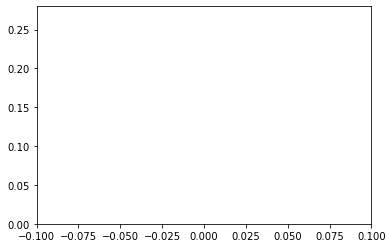

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML


# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

# ax.set_xlim((-0.1, 0.1))
# ax.set_ylim((0.0, 0.25))

ax.set_xlim((-0.1, 0.1))
ax.set_ylim((0, 0.28))

line, = ax.plot([], [], lw=10)

In [8]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
#     x = np.linspace(0, 0.15, 1000)
#     y = np.sin(2 * np.pi * (x - 0.01 * i))
    x = []
    y = []
    for j in range(0,50):       
        riltaur_legone.coupledMoveLeg()
        x.append(riltaur_legone.x)
        y.append(riltaur_legone.y)
#     print(min(y),max(y))
    line.set_data(x, y)
    return (line,)

                     #   sh,   da,   ua,   fp,   sl,   fq,  sd
gait_params = GaitParams(0.17, 0.08, 0.06, 0.4, 0.15, 0.5, 0.0)  # TROT
gait_gains = LegGain(80, 0.5, 50, 0.5)

riltaur_legone = motor(0.09, 0.16, 1.0, 0.0, gait_params)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=60, interval=100, blit=True)

# anim = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=100, interval=20, blit=True)


HTML(anim.to_html5_video())

-0.075


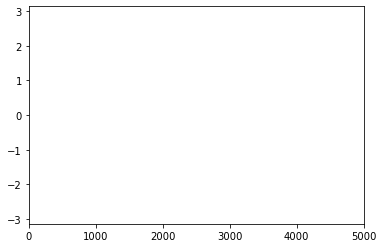

In [200]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML


# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim((0, 5000))
ax.set_ylim((-3.14, 3.14))
# ax.set_ylim((32000, 32768 + 768))

line, = ax.plot([], [], lw=5)
line2, = ax.plot([], [], lw=5)

In [201]:
""" this portion of the code is to return the position in 16 bits"""
# initialization function: plot the background of each frame

def init():
    line.set_data([], [])
    line2.set_data([], [])
    return (line, line2)

# animation function. This is called sequentially
def animate(i):
    alpha = []
    beta = []
    y = np.arange(0,5000)
    for j in range(0,5000):       
        riltaur_legone.coupledMoveLeg()
        alpha.append(riltaur_legone.theta)
        beta.append(riltaur_legone.gamma)
       
    line.set_data(y, alpha)
    line2.set_data(y, beta)
    return (line,line2)

                     #   sh,   da,   ua,   fp,   sl,   fq,  sd
gait_params = GaitParams(0.17, 0.08, 0.06, 0.4, 0.15, 1.0, 0.0)  # TROT
gait_gains = LegGain(80, 0.5, 50, 0.5)

riltaur_legone = motor(0.09, 0.16, 1.0, 0.0, gait_params)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=50, blit=True)


HTML(anim.to_html5_video())

In [7]:
time.time()

1606274827.6020029

##### 